In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 11.9 MB/s 


In [ ]:
!pip install -q "tqdm>=4.36.1"

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import zipfile
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow_datasets as tfds
import tqdm
import tensorflow_addons as tfa
from tensorflow.keras.utils import image_dataset_from_directory
from PIL import Image
import os
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import shutil
import matplotlib.pyplot as plt
import cv2 as cv2
from google.colab.patches import cv2_imshow


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/trainingSet_divided_centered_square.zip" -d "/content"

In [ ]:
!unzip -q "/content/drive/Shareddrives/DeepLearningProject/testSet.zip" -d "/content"

In [ ]:
!rm -r "/content/trainingSet/"
!rm -r "/content/validationSet/"

In [ ]:
!rm -r "/content/testSet/"

# Utility functions

### Create validation set

In [ ]:
def moveFilesToFolder(source, dest, list):
    for file_name in list:
        try:
            if ".jpeg" in file_name:
                shutil.move(source + file_name, dest)
            else:
                shutil.move(source + file_name + ".jpeg", dest)
        except:
            print(file_name)

def createValidation(pathFolder, validationPath, percentageValidation):
    filesToMove = []
    directory_contents = os.listdir(pathFolder)
    os.mkdir(validationPath)
    for directory in directory_contents:
        files = os.listdir(pathFolder + directory)
        currentPath = pathFolder + directory + "/"
        random.seed(123)
        random.shuffle(files)
        numFilesToMove = int(len(files) * percentageValidation)
        for i in range(numFilesToMove):
            filesToMove.append(files[i])
        os.mkdir(validationPath + directory)
        moveFilesToFolder(currentPath, validationPath + directory + "/", filesToMove)

        print(validationPath + directory + " created with " + str(len(os.listdir(validationPath + directory))) + " elements")

        filesToMove.clear()

In [ ]:
createValidation("/content/trainingSet/", "/content/validationSet/", 0.1 )

/content/validationSet/1 created with 244 elements
/content/validationSet/2 created with 529 elements
/content/validationSet/3 created with 87 elements
/content/validationSet/0 created with 2580 elements
/content/validationSet/4 created with 70 elements


### Balance classes

In [ ]:
def oversamplig(pathFolder, desiredSamples):
    numSamples = len(os.listdir(pathFolder))
    lap = 0
    print("num samples in: " + pathFolder + "\t " + str(numSamples) + " : " + str(desiredSamples))
    while (True):
        lap+=1
        for filename in os.listdir(pathFolder):
            image = Image.open(pathFolder + filename)
            filename = filename.split(".")[0] + "_" + "dup" + str(lap) + ".jpeg"
            image.save(pathFolder + filename)
            numSamples += 1
            if numSamples == desiredSamples:
                return


def undersampling(pathFolder, desiredSamples):
    listFiles = os.listdir(pathFolder)
    print("num samples in: " + pathFolder + "\t " + str(len(os.listdir(pathFolder))) + " : " + str(desiredSamples))
    filesToDelete = listFiles[desiredSamples:]
    for file in filesToDelete:
        os.remove(pathFolder + file)


def balanceClasses(pathFolder, desiredSamples):
    for directory in os.listdir(pathFolder):
        currentPath = pathFolder + directory + "/"
        numSamples = len(os.listdir(currentPath))
        if numSamples==desiredSamples:
            continue
        elif numSamples < desiredSamples:
            print("Start in folder: " + currentPath + "in mode OVERSAMPLING")
            oversamplig(currentPath, desiredSamples)
        else:
            print("Start in folder: " + currentPath + "in mode UNDERSAMPLING")
            undersampling(currentPath, desiredSamples)

        print("num samples in:  " + currentPath + "\t " + str(len(os.listdir(currentPath))))
        print()

In [ ]:
balanceClasses("/content/trainingSet/", 638)

Start in folder: /content/trainingSet/1/in mode UNDERSAMPLING
num samples in: /content/trainingSet/1/	 2199 : 638
num samples in:  /content/trainingSet/1/	 638

Start in folder: /content/trainingSet/2/in mode UNDERSAMPLING
num samples in: /content/trainingSet/2/	 4763 : 638
num samples in:  /content/trainingSet/2/	 638

Start in folder: /content/trainingSet/3/in mode UNDERSAMPLING
num samples in: /content/trainingSet/3/	 786 : 638
num samples in:  /content/trainingSet/3/	 638

Start in folder: /content/trainingSet/0/in mode UNDERSAMPLING
num samples in: /content/trainingSet/0/	 23228 : 638
num samples in:  /content/trainingSet/0/	 638



### Convert images to grayscale

In [ ]:
def toGrayScale(pathFolder):
    counter = 0
    for directory in os.listdir(pathFolder):
        currentPath = pathFolder + directory + "/"
        for filename in os.listdir(currentPath):
            try:
                image = Image.open(currentPath + filename).convert("L")
                image.save(currentPath + filename)
                counter += 1
                if counter % 1000 == 0:
                    print(str(counter) + " images to gray scale of directory " + str(directory))
            except Exception as e:
                print(filename + " Error " + str(e))

In [ ]:
toGrayScale("/content/trainingSet/")

### Apply CLAHE to images

In [ ]:
def clahe_rgb(input_path):
    bgr = cv2.imread(input_path)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    gridsize = 5
    clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr2 = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    cv2.imwrite("data/first.jpeg", bgr2)

    #cv2.imwrite(input_path, bgr2)
    '''
    #Removing the average color
    blurred = cv2.blur(img, ksize=(15, 15))
    dst = cv2.addWeighted(img, 4, blurred, -4, 128)
    '''
    #cv2_imshow( bgr2)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
def clahe_greyscale(input_path):
    img = cv2.imread(input_path)
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl1 = clahe.apply(gray_image)    
    cv2_imshow('CLAHE Grayscale', cl1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
def to_CLAHE(pathFolder):
    counter = 0
    for directory in os.listdir(pathFolder):
        currentPath = pathFolder + directory + "/"
        for filename in os.listdir(currentPath):
            try:
                clahe_rgb(currentPath + filename)
                counter += 1
                if counter % 100 == 0:
                    print(str(counter) + " images to CLAHE saved of directory " + str(directory))
            except Exception as e:
                print(filename + " Error " + str(e))

In [ ]:
to_CLAHE("/content/testSet/")

In [ ]:
clahe_rgb("/content/13_left.jpeg")

## Test data augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
  layers.RandomFlip("vertical"),
  layers.RandomFlip("horizontal"),
  layers.RandomZoom(0.1, fill_mode="constant", fill_value=0.0),
  layers.RandomRotation(factor=1, fill_mode="constant", fill_value=0.0),
  ]
)

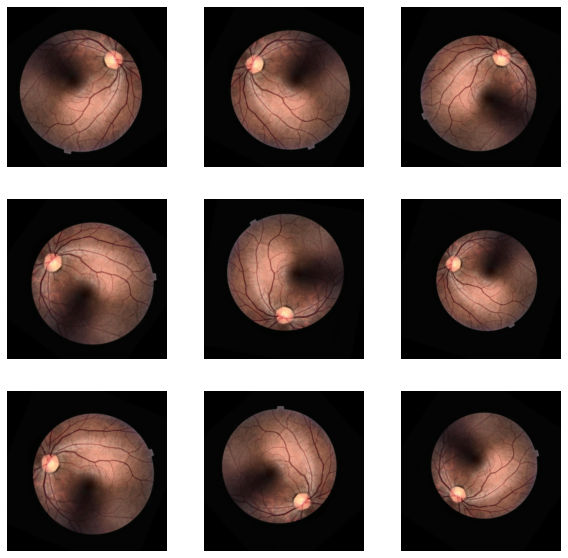

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        im = augmented_images[0].numpy().astype(np.uint8)
        #im = im[:,:,0]
        plt.imshow(im, vmin=0, vmax=255)
        plt.axis("off")

In [ ]:
!zip -r "/content/trainingSet.zip" "/content/trainingSet"

In [ ]:
!zip -r "/content/validationSet.zip" "/content/validationSet"